---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [44]:
import pandas as pd
df = pd.read_csv("electricity_train.csv")

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [3]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [4]:
df['class'].value_counts()

0    20860
1    15389
Name: class, dtype: int64

In [5]:
15389/(15389+20860)

0.4245358492648073

In [6]:
df.isnull().sum().sum()

0

Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

In [ ]:
# Постройте матрицу корреляций
correlation_matrix = df.corr()

# Найдите наиболее коррелированную пару признаков
max_corr = 0
max_corr_pair = ('', '')

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > max_corr:
            max_corr = abs(correlation_matrix.iloc[i, j])
            max_corr_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])

print("Наиболее коррелированная пара признаков:", max_corr_pair)
print("Коэффициент корреляции:", max_corr)

Наиболее коррелированная пара признаков: ('vicdemand', 'nswdemand')
Коэффициент корреляции: 0.6671743250710647


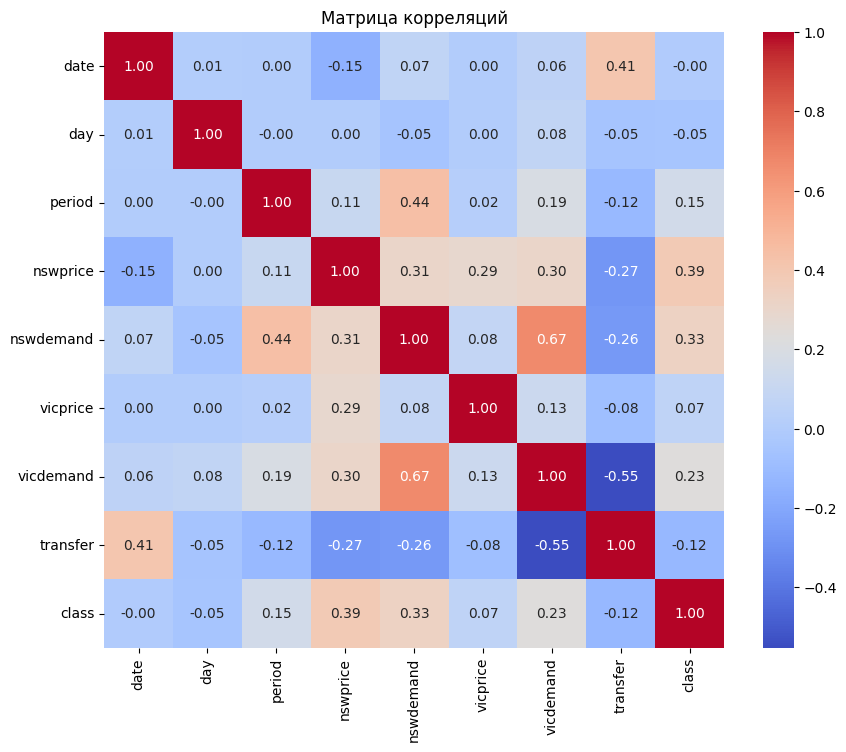

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций")
plt.show()

Постройте гистограммы распределений признаков.

In [ ]:
'''
import matplotlib.pyplot as plt

# Установите количество корзин
num_bins = 20

# Постройте гистограммы для каждого признака
for column in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=num_bins, edgecolor='k')
    plt.title(f'Гистограмма распределения признака {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

SyntaxError: ignored

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [45]:
from sklearn.model_selection import train_test_split

# Разбейте данные на тренировочную и тестовую выборки
X = df.drop(columns='class')  # Замените 'target_column' на имя вашего целевого признака
y = df['class']  # Замените 'target_column' на имя вашего целевого признака

# Установите параметры test_size и random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Теперь у вас есть тренировочные и тестовые выборки X_train, X_test, y_train, y_test

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Создайте и обучите модель RandomForestClassifier
model = RandomForestClassifier(random_state=33)
model.fit(X_train, y_train)

# Получите предсказания модели на тренировочных данных
y_pred = model.predict(X_train)

# Постройте classification_report
report = classification_report(y_train, y_pred, digits=3)

# Найдите значение точности модели на тренировочных данных
precision = float(report.split('\n')[2].split()[2])

print(report)
print("Точность модели на тренировочных данных:", precision)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     16675
           1      1.000     1.000     1.000     12324

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999

Точность модели на тренировочных данных: 1.0


Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
# < ENTER YOUR CODE HERE >

Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Определите параметры для подбора
params_grid = {
    'n_estimators': [100, 300, 500],
    'max_leaf_nodes': list(range(6, 10)),
    'min_samples_leaf': [1, 2, 3]
}

# Создайте объект RandomForestClassifier с начальными параметрами
initial_model = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=33
)

# Создайте GridSearchCV
grid_search = GridSearchCV(
    initial_model,
    params_grid,
    verbose=4,
    cv=3
)

# Обучите GridSearchCV на тренировочных данных
grid_search.fit(X_train, y_train)

# Получите лучшую модель
best_model = grid_search.best_estimator_

# Получите параметры лучшей модели
best_params = grid_search.best_params_

print("Лучшие параметры:", best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.775 total time=   1.2s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.772 total time=   1.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   1.2s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   4.9s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.772 total time=   3.6s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   3.6s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.774 total time=   7.1s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.772 total time=   5.9s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.774 total time=   8.5s
[CV 1/3] END max_leaf_nodes=6

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [33]:
best_model = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 9, min_samples_leaf = 1, random_state = 33)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=9, n_estimators=500, random_state=33)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [39]:
# Получите предсказания лучшей модели на тренировочных данных
y_pred_best = best_model.predict(X_train)

# Постройте classification_report
report_best = classification_report(y_train, y_pred_best, digits=3)

# Найдите значение точности модели на тренировочных данных
precision_best = float(report_best.split('\n')[2].split()[2])

print("Classification Report лучшей модели на тренировочных данных:")
print(report_best)
print("Точность модели на тренировочных данных:", precision_best)

Classification Report лучшей модели на тренировочных данных:
              precision    recall  f1-score   support

           0      0.779     0.877     0.825     16675
           1      0.800     0.664     0.725     12324

    accuracy                          0.786     28999
   macro avg      0.790     0.770     0.775     28999
weighted avg      0.788     0.786     0.783     28999

Точность модели на тренировочных данных: 0.877


Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [40]:
from sklearn.metrics import classification_report

# Получите предсказания лучшей модели на тестовых данных
y_pred_test = best_model.predict(X_test)

# Постройте classification_report
report_test = classification_report(y_test, y_pred_test, digits=3)

# Найдите значение точности модели на тестовых данных
precision_test = float(report_test.split('\n')[2].split()[2])

print("Classification Report лучшей модели на тестовых данных:")
print(report_test)
print("Точность модели на тестовых данных:", precision_test)

Classification Report лучшей модели на тестовых данных:
              precision    recall  f1-score   support

           0      0.782     0.882     0.829      4185
           1      0.804     0.664     0.727      3065

    accuracy                          0.790      7250
   macro avg      0.793     0.773     0.778      7250
weighted avg      0.791     0.790     0.786      7250

Точность модели на тестовых данных: 0.882


От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [ ]:
# Получите значения важности признаков из лучшей модели
feature_importances = best_model.feature_importances_

# Получите названия признаков
feature_names = X.columns

# Найдите индекс признака с максимальной важностью
most_important_feature_index = feature_importances.argmax()

# Найдите название самого важного признака
most_important_feature_name = feature_names[most_important_feature_index]

print("Самый важный признак модели:", most_important_feature_name)

Самый важный признак модели: nswprice


Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [29]:
logistic_classifier = LogisticRegression(solver='liblinear', random_state=33)
svc_classifier = SVC(random_state=33)
sgd_classifier = SGDClassifier(random_state=33)

# Создайте и обучите VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[('logistic', logistic_classifier), ('svc', svc_classifier), ('sgd', sgd_classifier)],
    voting='hard'
)

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(random_state=33,
                                                 solver='liblinear')),
                             ('svc', SVC(random_state=33)),
                             ('sgd', SGDClassifier(random_state=33))])

Вычислите точность модели на **тренировочных данных**

In [30]:
# Получите предсказания модели на тестовых данных
y_pred_voting = voting_classifier.predict(X_train)

# Постройте classification_report
report_voting = classification_report(y_train, y_pred_voting, digits=3)

# Найдите значение точности модели на тестовых данных
precision_voting = float(report_voting.split('\n')[2].split()[2])

print("Classification Report модели VotingClassifier на тестовых данных:")
print(report_voting)
print("Точность модели на тестовых данных:", precision_voting)

Classification Report модели VotingClassifier на тестовых данных:
              precision    recall  f1-score   support

           0      0.730     0.903     0.808     16675
           1      0.807     0.549     0.654     12324

    accuracy                          0.753     28999
   macro avg      0.769     0.726     0.731     28999
weighted avg      0.763     0.753     0.742     28999

Точность модели на тестовых данных: 0.903


Вычислите точность модели на **тестовых данных**

In [32]:
# Получите предсказания модели на тестовых данных
y_pred_voting = voting_classifier.predict(X_test)

# Постройте classification_report
report_voting = classification_report(y_test, y_pred_voting, digits=3)

# Найдите значение точности модели на тестовых данных
precision_voting = float(report_voting.split('\n')[2].split()[2])

print("Classification Report модели VotingClassifier на тестовых данных:")
print(report_voting)
print("Точность модели на тестовых данных:", precision_voting)

Classification Report модели VotingClassifier на тестовых данных:
              precision    recall  f1-score   support

           0      0.727     0.908     0.808      4185
           1      0.810     0.535     0.645      3065

    accuracy                          0.750      7250
   macro avg      0.769     0.722     0.726      7250
weighted avg      0.762     0.750     0.739      7250

Точность модели на тестовых данных: 0.908


# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Создайте BaggingClassifier с DecisionTreeClassifier внутри
bagging_classifier = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
    random_state=33
)

# Обучите модель на тренировочных данных
bagging_classifier.fit(X_train, y_train)

# Получите предсказания модели на тестовых данных
y_pred_bagging = bagging_classifier.predict(X_test)

# Постройте classification_report
report_bagging = classification_report(y_test, y_pred_bagging, digits=3)

# Найдите значение точности модели на тестовых данных
precision_bagging = float(report_bagging.split('\n')[2].split()[2])

print("Classification Report модели BaggingClassifier на тестовых данных:")
print(report_bagging)
print("Точность модели на тестовых данных:", precision_bagging)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Report модели BaggingClassifier на тестовых данных:
              precision    recall  f1-score   support

           0      0.851     0.923     0.886      4185
           1      0.881     0.780     0.827      3065

    accuracy                          0.862      7250
   macro avg      0.866     0.851     0.857      7250
weighted avg      0.864     0.862     0.861      7250

Точность модели на тестовых данных: 0.923


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Создайте и обучите модель GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.8,
    random_state=33,
    max_depth=2
)
gb_classifier.fit(X_train, y_train)

# Получите предсказания модели на тестовых данных
y_pred_gb = gb_classifier.predict(X_test)

# Постройте classification_report
report_gb = classification_report(y_test, y_pred_gb, digits=3)

# Найдите значение точности модели на тестовых данных
precision_gb = float(report_gb.split('\n')[2].split()[2])

print("Classification Report модели GradientBoostingClassifier на тестовых данных:")
print(report_gb)
print("Точность модели на тестовых данных:", precision_gb)

Classification Report модели GradientBoostingClassifier на тестовых данных:
              precision    recall  f1-score   support

           0      0.903     0.923     0.913      4185
           1      0.892     0.865     0.878      3065

    accuracy                          0.899      7250
   macro avg      0.898     0.894     0.896      7250
weighted avg      0.898     0.899     0.898      7250

Точность модели на тестовых данных: 0.923


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Создайте AdaBoostClassifier с DecisionTreeClassifier внутри
ada_boost_classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=33
)

# Обучите модель на тренировочных данных
ada_boost_classifier.fit(X_train, y_train)

# Получите предсказания модели на тестовых данных
y_pred_ada_boost = ada_boost_classifier.predict(X_test)

# Постройте classification_report
report_ada_boost = classification_report(y_test, y_pred_ada_boost, digits=3)

# Найдите значение точности модели на тестовых данных
precision_ada_boost = float(report_ada_boost.split('\n')[2].split()[2])

print("Classification Report модели AdaBoostClassifier на тестовых данных:")
print(report_ada_boost)
print("Точность модели на тестовых данных:", precision_ada_boost)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Report модели AdaBoostClassifier на тестовых данных:
              precision    recall  f1-score   support

           0      0.917     0.905     0.911      4185
           1      0.872     0.888     0.880      3065

    accuracy                          0.898      7250
   macro avg      0.895     0.897     0.896      7250
weighted avg      0.898     0.898     0.898      7250

Точность модели на тестовых данных: 0.905


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [14]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Определите базовые алгоритмы
base_estimators = [
    ('random_forest', RandomForestClassifier(random_state=33)),
    ('svc', SVC(random_state=33))
]

# Определите решающий алгоритм
final_estimator = LogisticRegression(random_state=33)

# Создайте и обучите модель StackingClassifier
stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)

stacking_classifier.fit(X_train, y_train)

# Получите предсказания модели на тестовых данных
y_pred_stacking = stacking_classifier.predict(X_test)

# Постройте classification_report
report_stacking = classification_report(y_test, y_pred_stacking, digits=3)

# Найдите значение точности модели на тестовых данных
precision_stacking = float(report_stacking.split('\n')[2].split()[2])

print("Classification Report модели StackingClassifier на тестовых данных:")
print(report_stacking)
print("Точность модели на тестовых данных:", precision_stacking)

Classification Report модели StackingClassifier на тестовых данных:
              precision    recall  f1-score   support

           0      0.906     0.929     0.917      4185
           1      0.900     0.868     0.883      3065

    accuracy                          0.903      7250
   macro avg      0.903     0.898     0.900      7250
weighted avg      0.903     0.903     0.903      7250

Точность модели на тестовых данных: 0.929


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

---

# 2 Task

In [41]:
X_test = pd.read_csv("electricity_reserved.csv")
X_test.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.881111,3,0.595745,0.035937,0.527968,0.002443,0.545054,0.391667
1,0.898854,7,0.744681,0.084514,0.529902,0.005399,0.449249,0.664474
2,0.452015,4,0.000000,0.040891,0.591639,0.002833,0.449508,0.491667
3,0.446706,3,0.893617,0.069893,0.623921,0.004701,0.486277,0.586842
4,0.890005,2,0.914894,0.027441,0.577060,0.001901,0.528742,0.419298


In [42]:
df = pd.read_csv("electricity_train.csv")

X_train = df.drop(columns='class')
y_train = df['class']

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Создайте и обучите модель GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.8,
    random_state=33,
    max_depth=2
)
gb_classifier.fit(X_train, y_train)

# Получите предсказания модели на тестовых данных
y_pred_gb = gb_classifier.predict(X_test)

# 3

In [65]:
import telebot 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# df = pd.read_csv("electricity-normalized.csv")
X_train = df.drop(columns='class')
y_train = df['class']

X_test = pd.read_csv("electricity_reserved.csv")


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=33)
TOKENTG = 
bot = telebot.TeleBot(TOKENTG)

def send_message(message):
    chat_id = 
    bot.send_message(chat_id, message)
        


if __name__ == "__main__":
    base_estimators = [
        ('random_forest', RandomForestClassifier(n_estimators = 300, max_depth = 20, random_state=33)),
        ('svc', SVC(C = 10, kernel='rbf', random_state=33)),
        ('lgb', lgb.LGBMClassifier(n_estimators = 200, learning_rate = 0.1, random_state=33)),
        ('lr', LogisticRegression(max_iter = 200, random_state=33)), 
        ('DT', DecisionTreeClassifier(max_depth = 20, random_state=33))
    ]

    # Define LightGBM as the final estimator
    final_estimator = GradientBoostingClassifier(random_state=33)


    # Create and train the StackingClassifier model
    stacking_classifier = StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator
    )

    stacking_classifier.fit(X_train, y_train)

    
    #y_pred_stacking = stacking_classifier.predict(X_test)

    
    #report_stacking = classification_report(y_test, y_pred_stacking, digits=3)

    #print(report_stacking)
